In [5]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
from matplotlib.lines import Line2D
from lmfit import Model
import warnings

In [6]:
RAWDATA = Path('/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/rawdata')
FILLINFO       = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/2025/fills-info")
fbmodes        = pd.read_parquet(FILLINFO / "fills_and_bmodes_2025.parquet")
fill = 10739

In [7]:
# Extract just fill 10739
fb_10739 = fbmodes.loc[10739]

# Print it out
print(f"\nModes for fill 10739 (total {len(fb_10739)} rows):\n")
print(fb_10739.sort_values("tsStart"))



Modes for fill 10739 (total 12 rows):

           BMODE              tsStart                tsEnd   QFLAG  \
FILLNO                                                               
10739       FILL  1750379728146238525  1750403378930738525  STABLE   
10739    INJPHYS  1750379728146238525  1750379762505988525  STABLE   
10739    INJPROB  1750379762505988525  1750380060404363525  STABLE   
10739    INJPHYS  1750380060404363525  1750381006905238525  STABLE   
10739    PRERAMP  1750381006905238525  1750381104551238525  STABLE   
10739       RAMP  1750381104551238525  1750382389608863525  STABLE   
10739    FLATTOP  1750382389608863525  1750382769695488525  STABLE   
10739    SQUEEZE  1750382769695488525  1750384065177488525  STABLE   
10739     ADJUST  1750384065177488525  1750384437456613525  STABLE   
10739     STABLE  1750384437456613525  1750403331481488525  STABLE   
10739   BEAMDUMP  1750403331481488525  1750403336031238525  STABLE   
10739   RAMPDOWN  1750403336031238525  17504033789

In [8]:
beam = 'B2'
ip = '1'
# ---------------------------------------------
int_var   = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
bsrt_loc = '5R4' if beam.upper() == 'B1' else '5L4'
int_var   = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
emitH_var = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H"
emitV_var = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V"
loss_b1 = 'UCAP.LHC.LUMI.LOSSES:EffectiveCrossSectionPerBunch:effectiveCrossSectionB1'
loss_b2 = "UCAP.LHC.LUMI.LOSSES:EffectiveCrossSectionPerBunch:effectiveCrossSectionB2"
lev_pv = "LHC.LUMISERVER:LumiLevelingIP1:Enable"
beta_pv     = "HX:BETASTAR_IP1"
xing_pv     = "LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value"


In [9]:
from pathlib import Path
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# CONFIG (adjust to your environment)
# ─────────────────────────────────────────────────────────────────────────────
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363")
# ─────────────────────────────────────────────────────────────────────────────

def load_INJPHYS_series(fill_num: int, pv_name: str, datadir: Path = DATADIR) -> pd.Series:
    """
    Load a single PV over the entire INJPHYS period of a given fill.
    
    Parameters
    ----------
    fill_num : int
        The fill number (e.g. 10739).
    pv_name : str
        The name of the process variable (column) to load.
    datadir : Path
        Root directory containing HX:FILLN=<fill> subfolders.
    
    Returns
    -------
    pd.Series
        A tz‐aware (UTC) time series of that PV, concatenated and sorted
        across all Parquet files in the INJPHYS folder.
    
    Raises
    ------
    RuntimeError
        If no data is found for that PV in INJPHYS.
    """
    inj_dir = datadir / f"HX:FILLN={fill_num}" / "HX:BMODE=INJPHYS"
    parts = []
    for pq in inj_dir.rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[pv_name])
        except (KeyError, ValueError):
            # file does not contain this PV or is corrupted
            continue
        # convert to numeric (if scalar) or leave array dtype
        ser = df[pv_name]
        ser.index = pd.to_datetime(df.index, utc=True, unit="ns", errors="coerce")
        parts.append(ser.dropna())
    if not parts:
        raise RuntimeError(f"No INJPHYS data found for {pv_name!r} in fill {fill_num}")
    full = pd.concat(parts).sort_index()
    full.name = pv_name
    return full

def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    """
    Given an array‐valued series (nTimes×nBuckets), pull out one bucket.
    """
    return ser.map(lambda arr: arr[slot] if hasattr(arr, "__len__") and len(arr) > slot else np.nan)

# ─────────────────────────────────────────────────────────────────────────────
# Example usage:
# ─────────────────────────────────────────────────────────────────────────────
fill = 10739 
bsrt_loc = "5R4" if beam == "B1" else "5L4"

# Intensity is array‐valued: pick bucket 20
I_ser = load_INJPHYS_series(fill, f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY")
slot20_I = extract_slot(I_ser, 20)

# Emittance H/V for the same slot
H_ser = load_INJPHYS_series(fill, f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H")
slot20_H = extract_slot(H_ser, 20)

V_ser = load_INJPHYS_series(fill, f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V")
slot20_V = extract_slot(V_ser, 20)

print("First and last INJPHYS timestamps for slot 20:")
print(" Intensity:", slot20_I.index[[0, -1]])
print(" Emittance H:", slot20_H.index[[0, -1]])
print(" Emittance V:", slot20_V.index[[0, -1]])


First and last INJPHYS timestamps for slot 20:
 Intensity: DatetimeIndex(['2025-06-20 00:35:35.000363525+00:00', '2025-06-20 00:56:42.000363525+00:00'], dtype='datetime64[ns, UTC]', freq=None)
 Emittance H: DatetimeIndex(['2025-06-20 00:41:08.108443725+00:00', '2025-06-20 00:56:44.180155400+00:00'], dtype='datetime64[ns, UTC]', freq=None)
 Emittance V: DatetimeIndex(['2025-06-20 00:41:08.108443725+00:00', '2025-06-20 00:56:44.180155400+00:00'], dtype='datetime64[ns, UTC]', freq=None)


# Injection

In [10]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from pathlib import Path

# ---------------------------------------------
# CONFIG
# ---------------------------------------------
DATADIR  = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363")
fno      = 10739
beam     = "B2"     # or "B2"
SOLO_BID = 100

# these are your two possible slot lists:
idx_b1 = [20, 500, 750, 1250, 1800, 2250, 2874]
idx_b2 = [20, 500, 1050, 1250, 1800, 2500, 2874]

# pick the right one:
slot_list = idx_b1 if beam.upper() == "B1" else idx_b2

# include SOLO_BID if you still want it:
all_bids = [*slot_list, SOLO_BID]


# ---------------------------------------------
# New loader: only read the parquet files for one fill
# ---------------------------------------------
def load_bunch_array_for_fill(pv_name: str, bid_list, fill_num: int):
    """Load only from DATADIR/HX:FILLN={fill_num}/… so we see the correct non-zero slots."""
    path = DATADIR / f"HX:FILLN={fill_num}"
    raw = (
        dd.read_parquet(str(path / "**" / "*.parquet"),
                        columns=[pv_name],
                        engine="pyarrow",
                        gather_statistics=False)
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)

    mat    = np.stack(raw[pv_name].values)  # nTimes × nBuckets
    sliced = mat[:, bid_list]
    return pd.DataFrame(
        sliced,
        index   = raw.index,
        columns = [f"B{bid}" for bid in bid_list]
    )

# ---------------------------------------------
# Build PV names
# ---------------------------------------------
bsrt_loc    = '5R4' if beam.upper()=="B1" else '5L4'
PV_INT      = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
PV_EMIT_H   = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H"
PV_EMIT_V   = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V"

# ---------------------------------------------
# Load DataFrames for fill 10739 only
# ---------------------------------------------
df_intensity = load_bunch_array_for_fill(PV_INT,    all_bids, fno)
df_emitH     = load_bunch_array_for_fill(PV_EMIT_H, all_bids, fno)
df_emitV     = load_bunch_array_for_fill(PV_EMIT_V, all_bids, fno)

# ---------------------------------------------
# Drop solo bunch and any still-zero columns
# ---------------------------------------------
to_drop = [f"B{SOLO_BID}"]
for df in (df_intensity, df_emitH, df_emitV):
    df.drop(columns=to_drop, errors='ignore', inplace=True)
    zero_cols = [c for c in df.columns if (df[c] == 0).all()]
    df.drop(columns=zero_cols, inplace=True)

# ---------------------------------------------
# Inspect results
# ---------------------------------------------
print("Intensity (slots with data):")
display(df_intensity.head())

print("Horizontal emittance:")
display(df_emitH.head())

print("Vertical emittance:")
display(df_emitV.head())

# ---------------------------------------------
# Save CSVs if desired
# ---------------------------------------------
cwd = Path.cwd()
df_intensity.to_csv(cwd / f"intensity_fill{fno}.csv", index_label="timestamp")
df_emitH.    to_csv(cwd / f"emittanceH_fill{fno}.csv", index_label="timestamp")
df_emitV.    to_csv(cwd / f"emittanceV_fill{fno}.csv", index_label="timestamp")

print("Written CSV files:")
print("  intensity_fill{fno}.csv")
print("  emittanceH_fill{fno}.csv")
print("  emittanceV_fill{fno}.csv")


Intensity (slots with data):


,B20,B500,B1050,B1250,B1800,B2500,B2874
2025-06-20 00:35:35.000363525,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:35:38.000363525,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:35:55.000363525,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:36:01.000363525,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:36:17.000363525,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Horizontal emittance:


,B20,B500,B1050,B1250,B1800,B2500,B2874
2025-06-20 00:38:57.286575825,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:39:07.348546600,0.0,3.306237,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:39:18.298380500,0.0,3.217728,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:39:29.207372525,0.0,3.205902,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:39:40.266844375,0.0,3.288100,0.0,0.0,0.0,0.0,0.0


Vertical emittance:


,B20,B500,B1050,B1250,B1800,B2500,B2874
2025-06-20 00:38:57.286575825,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:39:07.348546600,0.0,2.237876,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:39:18.298380500,0.0,2.282772,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:39:29.207372525,0.0,2.275121,0.0,0.0,0.0,0.0,0.0
2025-06-20 00:39:40.266844375,0.0,2.200165,0.0,0.0,0.0,0.0,0.0


Written CSV files:
  intensity_fill{fno}.csv
  emittanceH_fill{fno}.csv
  emittanceV_fill{fno}.csv


In [11]:
import numpy as np
import pandas as pd

# ---------------------------------------------
# Before this snippet, you should have:
#   df_intensity, df_emitH, df_emitV loaded & cleaned
#   beam defined as "B1" or "B2"
# ---------------------------------------------

# define the two possible slot lists
idx_b1 = [20, 500, 750, 1250, 1800, 2250, 2874]
idx_b2 = [20, 500, 1050, 1250, 1800, 2500, 2874]

# pick based on beam
slot_list = idx_b1 if beam.upper() == "B1" else idx_b2

results = {}

for bid in slot_list:
    col = f"B{bid}"
    if col not in df_intensity.columns:
        print(f"Skipping B{bid}: not present in intensity DataFrame")
        continue

    int_ser = df_intensity[col]
    H_ser   = df_emitH[col]
    V_ser   = df_emitV[col]

    # 1) all nonzero‐intensity times+values
    nz = int_ser[int_ser > 0]

    recs = []
    for t_int, i_val in nz.items():
        # 2) emittance at exactly t_int (NaN if no exact timestamp)
        H_at = H_ser.get(t_int, np.nan)
        V_at = V_ser.get(t_int, np.nan)

        # 3) next emittance after t_int
        idx_H = H_ser.index.searchsorted(t_int, side='right')
        if idx_H < len(H_ser):
            t_Hn = H_ser.index[idx_H]
            H_n  = H_ser.iloc[idx_H]
        else:
            t_Hn, H_n = pd.NaT, np.nan

        idx_V = V_ser.index.searchsorted(t_int, side='right')
        if idx_V < len(V_ser):
            t_Vn = V_ser.index[idx_V]
            V_n  = V_ser.iloc[idx_V]
        else:
            t_Vn, V_n = pd.NaT, np.nan

        recs.append({
            "int_ts":      t_int,
            "intensity":   i_val,
            "H_ts_at":     t_int if not pd.isna(H_at) else pd.NaT,
            "H_at":        H_at,
            "V_ts_at":     t_int if not pd.isna(V_at) else pd.NaT,
            "V_at":        V_at,
            "H_next_ts":   t_Hn,
            "H_next_val":  H_n,
            "V_next_ts":   t_Vn,
            "V_next_val":  V_n,
        })

    df_bid = pd.DataFrame(recs)
    results[bid] = df_bid

    print(f"\n=== Results for B{bid} ===")
    display(df_bid)



=== Results for B20 ===


,int_ts,intensity,H_ts_at,H_at,V_ts_at,V_at,H_next_ts,H_next_val,V_next_ts,V_next_val
0,2025-06-20 00:42:18.000363525,2.140165e+11,NaT,NaN,NaT,NaN,2025-06-20 00:42:23.721840100,1.996032,2025-06-20 00:42:23.721840100,1.688787
1,2025-06-20 00:42:21.000363525,2.140038e+11,NaT,NaN,NaT,NaN,2025-06-20 00:42:23.721840100,1.996032,2025-06-20 00:42:23.721840100,1.688787
2,2025-06-20 00:42:27.000363525,2.140151e+11,NaT,NaN,NaT,NaN,2025-06-20 00:42:34.763860550,1.989988,2025-06-20 00:42:34.763860550,1.658972
3,2025-06-20 00:42:28.000363525,2.140082e+11,NaT,NaN,NaT,NaN,2025-06-20 00:42:34.763860550,1.989988,2025-06-20 00:42:34.763860550,1.658972
4,2025-06-20 00:42:30.000363525,2.140054e+11,NaT,NaN,NaT,NaN,2025-06-20 00:42:34.763860550,1.989988,2025-06-20 00:42:34.763860550,1.658972
...,...,...,...,...,...,...,...,...,...,...
9373,2025-06-20 07:07:35.000363525,1.723700e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.345453,2025-06-20 07:07:38.892885175,2.277162
9374,2025-06-20 07:07:38.000363525,1.723618e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.345453,2025-06-20 07:07:38.892885175,2.277162
9375,2025-06-20 07:07:42.000363525,1.723521e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9376,2025-06-20 07:07:43.000363525,1.723604e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN



=== Results for B500 ===


,int_ts,intensity,H_ts_at,H_at,V_ts_at,V_at,H_next_ts,H_next_val,V_next_ts,V_next_val
0,2025-06-20 00:39:00.000363525,1.016287e+10,NaT,NaN,NaT,NaN,2025-06-20 00:39:07.348546600,3.306237,2025-06-20 00:39:07.348546600,2.237876
1,2025-06-20 00:39:01.000363525,1.016707e+10,NaT,NaN,NaT,NaN,2025-06-20 00:39:07.348546600,3.306237,2025-06-20 00:39:07.348546600,2.237876
2,2025-06-20 00:39:02.000363525,1.016473e+10,NaT,NaN,NaT,NaN,2025-06-20 00:39:07.348546600,3.306237,2025-06-20 00:39:07.348546600,2.237876
3,2025-06-20 00:39:09.000363525,1.016676e+10,NaT,NaN,NaT,NaN,2025-06-20 00:39:18.298380500,3.217728,2025-06-20 00:39:18.298380500,2.282772
4,2025-06-20 00:39:12.000363525,1.016748e+10,NaT,NaN,NaT,NaN,2025-06-20 00:39:18.298380500,3.217728,2025-06-20 00:39:18.298380500,2.282772
...,...,...,...,...,...,...,...,...,...,...
9423,2025-06-20 07:07:35.000363525,1.747945e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.298244,2025-06-20 07:07:38.892885175,2.193572
9424,2025-06-20 07:07:38.000363525,1.748043e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.298244,2025-06-20 07:07:38.892885175,2.193572
9425,2025-06-20 07:07:42.000363525,1.747857e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9426,2025-06-20 07:07:43.000363525,1.747765e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN



=== Results for B1050 ===


,int_ts,intensity,H_ts_at,H_at,V_ts_at,V_at,H_next_ts,H_next_val,V_next_ts,V_next_val
0,2025-06-20 00:44:12.000363525,1.111367e+11,NaT,NaN,NaT,NaN,2025-06-20 00:44:22.227798325,1.919543,2025-06-20 00:44:22.227798325,1.669764
1,2025-06-20 00:44:17.000363525,2.135847e+11,NaT,NaN,NaT,NaN,2025-06-20 00:44:22.227798325,1.919543,2025-06-20 00:44:22.227798325,1.669764
2,2025-06-20 00:44:27.000363525,2.135709e+11,NaT,NaN,NaT,NaN,2025-06-20 00:44:32.652630900,1.932757,2025-06-20 00:44:32.652630900,1.651340
3,2025-06-20 00:44:30.000363525,2.135693e+11,NaT,NaN,NaT,NaN,2025-06-20 00:44:32.652630900,1.932757,2025-06-20 00:44:32.652630900,1.651340
4,2025-06-20 00:44:31.000363525,2.135579e+11,NaT,NaN,NaT,NaN,2025-06-20 00:44:32.652630900,1.932757,2025-06-20 00:44:32.652630900,1.651340
...,...,...,...,...,...,...,...,...,...,...
9343,2025-06-20 07:07:35.000363525,2.086601e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.050570,2025-06-20 07:07:38.892885175,1.932008
9344,2025-06-20 07:07:38.000363525,2.086757e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.050570,2025-06-20 07:07:38.892885175,1.932008
9345,2025-06-20 07:07:42.000363525,2.086642e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9346,2025-06-20 07:07:43.000363525,2.086642e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN



=== Results for B1250 ===


,int_ts,intensity,H_ts_at,H_at,V_ts_at,V_at,H_next_ts,H_next_val,V_next_ts,V_next_val
0,2025-06-20 00:47:44.000363525,2.186161e+11,NaT,NaN,NaT,NaN,2025-06-20 00:47:44.748626875,1.773762,2025-06-20 00:47:44.748626875,1.563565
1,2025-06-20 00:47:46.000363525,2.186028e+11,NaT,NaN,NaT,NaN,2025-06-20 00:47:55.317125875,1.788623,2025-06-20 00:47:55.317125875,1.585909
2,2025-06-20 00:48:02.000363525,2.185805e+11,NaT,NaN,NaT,NaN,2025-06-20 00:48:05.895874075,1.784026,2025-06-20 00:48:05.895874075,1.592228
3,2025-06-20 00:48:06.000363525,2.185739e+11,NaT,NaN,NaT,NaN,2025-06-20 00:48:16.697355675,1.779295,2025-06-20 00:48:16.697355675,1.584630
4,2025-06-20 00:48:11.000363525,2.185702e+11,NaT,NaN,NaT,NaN,2025-06-20 00:48:16.697355675,1.779295,2025-06-20 00:48:16.697355675,1.584630
...,...,...,...,...,...,...,...,...,...,...
9298,2025-06-20 07:07:35.000363525,1.678526e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.492731,2025-06-20 07:07:38.892885175,2.391610
9299,2025-06-20 07:07:38.000363525,1.678535e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.492731,2025-06-20 07:07:38.892885175,2.391610
9300,2025-06-20 07:07:42.000363525,1.678349e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9301,2025-06-20 07:07:43.000363525,1.678241e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN



=== Results for B1800 ===


,int_ts,intensity,H_ts_at,H_at,V_ts_at,V_at,H_next_ts,H_next_val,V_next_ts,V_next_val
0,2025-06-20 00:48:40.000363525,2.174893e+11,NaT,NaN,NaT,NaN,2025-06-20 00:48:48.433314625,1.770963,2025-06-20 00:48:48.433314625,1.616081
1,2025-06-20 00:48:42.000363525,2.174827e+11,NaT,NaN,NaT,NaN,2025-06-20 00:48:48.433314625,1.770963,2025-06-20 00:48:48.433314625,1.616081
2,2025-06-20 00:48:49.000363525,2.174774e+11,NaT,NaN,NaT,NaN,2025-06-20 00:48:58.836097325,1.779216,2025-06-20 00:48:58.836097325,1.588937
3,2025-06-20 00:48:52.000363525,2.174573e+11,NaT,NaN,NaT,NaN,2025-06-20 00:48:58.836097325,1.779216,2025-06-20 00:48:58.836097325,1.588937
4,2025-06-20 00:48:53.000363525,2.174753e+11,NaT,NaN,NaT,NaN,2025-06-20 00:48:58.836097325,1.779216,2025-06-20 00:48:58.836097325,1.588937
...,...,...,...,...,...,...,...,...,...,...
9288,2025-06-20 07:07:35.000363525,1.667718e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.514364,2025-06-20 07:07:38.892885175,2.386876
9289,2025-06-20 07:07:38.000363525,1.667759e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.514364,2025-06-20 07:07:38.892885175,2.386876
9290,2025-06-20 07:07:42.000363525,1.667571e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9291,2025-06-20 07:07:43.000363525,1.667640e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN



=== Results for B2500 ===


,int_ts,intensity,H_ts_at,H_at,V_ts_at,V_at,H_next_ts,H_next_val,V_next_ts,V_next_val
0,2025-06-20 00:49:29.000363525,1.554889e+11,NaT,NaN,NaT,NaN,2025-06-20 00:49:30.595426325,1.824244,2025-06-20 00:49:30.595426325,1.602525
1,2025-06-20 00:49:35.000363525,2.146228e+11,NaT,NaN,NaT,NaN,2025-06-20 00:49:41.028157750,1.803939,2025-06-20 00:49:41.028157750,1.634168
2,2025-06-20 00:49:38.000363525,2.146481e+11,NaT,NaN,NaT,NaN,2025-06-20 00:49:41.028157750,1.803939,2025-06-20 00:49:41.028157750,1.634168
3,2025-06-20 00:49:39.000363525,2.146393e+11,NaT,NaN,NaT,NaN,2025-06-20 00:49:41.028157750,1.803939,2025-06-20 00:49:41.028157750,1.634168
4,2025-06-20 00:49:41.000363525,2.146281e+11,NaT,NaN,NaT,NaN,2025-06-20 00:49:41.028157750,1.803939,2025-06-20 00:49:41.028157750,1.634168
...,...,...,...,...,...,...,...,...,...,...
9272,2025-06-20 07:07:35.000363525,2.078571e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.307012,2025-06-20 07:07:38.892885175,2.192582
9273,2025-06-20 07:07:38.000363525,2.078613e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,2.307012,2025-06-20 07:07:38.892885175,2.192582
9274,2025-06-20 07:07:42.000363525,2.078493e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9275,2025-06-20 07:07:43.000363525,2.078551e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN



=== Results for B2874 ===


,int_ts,intensity,H_ts_at,H_at,V_ts_at,V_at,H_next_ts,H_next_val,V_next_ts,V_next_val
0,2025-06-20 00:52:24.000363525,1.524255e+11,NaT,NaN,NaT,NaN,2025-06-20 00:52:30.154039725,1.494437,2025-06-20 00:52:30.154039725,1.315483
1,2025-06-20 00:52:25.000363525,1.524251e+11,NaT,NaN,NaT,NaN,2025-06-20 00:52:30.154039725,1.494437,2025-06-20 00:52:30.154039725,1.315483
2,2025-06-20 00:52:27.000363525,1.524053e+11,NaT,NaN,NaT,NaN,2025-06-20 00:52:30.154039725,1.494437,2025-06-20 00:52:30.154039725,1.315483
3,2025-06-20 00:52:28.000363525,1.524042e+11,NaT,NaN,NaT,NaN,2025-06-20 00:52:30.154039725,1.494437,2025-06-20 00:52:30.154039725,1.315483
4,2025-06-20 00:52:30.000363525,1.523994e+11,NaT,NaN,NaT,NaN,2025-06-20 00:52:30.154039725,1.494437,2025-06-20 00:52:30.154039725,1.315483
...,...,...,...,...,...,...,...,...,...,...
9211,2025-06-20 07:07:35.000363525,1.213688e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,6.141204,2025-06-20 07:07:38.892885175,2.579604
9212,2025-06-20 07:07:38.000363525,1.213668e+11,NaT,NaN,NaT,NaN,2025-06-20 07:07:38.892885175,6.141204,2025-06-20 07:07:38.892885175,2.579604
9213,2025-06-20 07:07:42.000363525,1.213610e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
9214,2025-06-20 07:07:43.000363525,1.213546e+11,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN



B20 injection fit:
  H: [2025-06-20 00:42:23.721840100+00:00 → 2025-06-20 00:56:44.180155400+00:00]  slope=9.371e-01 ± 2.073e-02
  V: [2025-06-20 00:42:23.721840100+00:00 → 2025-06-20 00:56:44.180155400+00:00]  slope=3.606e-01 ± 3.338e-02

B500 injection fit:
  H: [2025-06-20 00:41:08.108443725+00:00 → 2025-06-20 00:56:44.180155400+00:00]  slope=1.080e+00 ± 8.534e+00
  V: [2025-06-20 00:41:08.108443725+00:00 → 2025-06-20 00:56:44.180155400+00:00]  slope=4.487e-01 ± 5.616e+00

B1050 injection fit:
  H: [2025-06-20 00:44:22.227798325+00:00 → 2025-06-20 00:56:44.180155400+00:00]  slope=8.933e-01 ± 2.652e-02
  V: [2025-06-20 00:44:22.227798325+00:00 → 2025-06-20 00:56:44.180155400+00:00]  slope=3.164e-01 ± 4.995e-02

B1250 injection fit:
  H: [2025-06-20 00:47:44.748626875+00:00 → 2025-06-20 00:56:44.180155400+00:00]  slope=1.498e+00 ± nan
  V: [2025-06-20 00:47:44.748626875+00:00 → 2025-06-20 00:56:44.180155400+00:00]  slope=5.453e-01 ± nan

B1800 injection fit:
  H: [2025-06-20 00:48:48

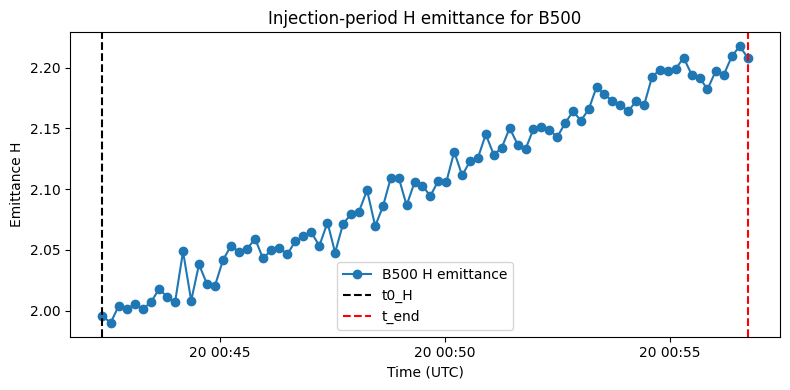

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from lmfit import Model
import warnings
import dask.dataframe as dd

# -----------------------------
# CONFIG
# -----------------------------
DATADIR    = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363")  
FNO        = 10739
BEAM       = "B2"
IDX_B1     = [20, 500, 750, 1250, 1800, 2250, 2874]
IDX_B2     = [20, 500, 1050, 1250, 1800, 2500, 2874]
BUNCH_IDS  = IDX_B1 if BEAM=="B1" else IDX_B2

BSRT_LOC   = "5R4" if BEAM=="B1" else "5L4"
PV_INT     = f"LHC.BCTFR.B6R4.{BEAM}:BUNCH_INTENSITY"
PV_EMIT_H  = f"LHC.BSRT.{BSRT_LOC}.{BEAM}:BUNCH_EMITTANCE_H"
PV_EMIT_V  = f"LHC.BSRT.{BSRT_LOC}.{BEAM}:BUNCH_EMITTANCE_V"

# Fit settings
F_SCALE       = 0.1
REL_ERR       = 0.05
ABS_ERR_FLOOR = 0.02
MIN_ERR       = 1e-12
MIN_PTS       = 5
MIN_DT_H      = 0.15   # hours ≃ 9 min
MAX_WEIGHT    = 1e4

# -----------------------------
# HELPERS
# -----------------------------
_line_model = Model(lambda x, m, b: m*x + b)

def robust_line(xh, y, f_scale=F_SCALE):
    yerr = np.maximum(np.maximum(REL_ERR*np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w    = np.minimum(1.0 / yerr, MAX_WEIGHT)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        res = _line_model.fit(
            y, x=xh, m=0.0, b=y[0],
            weights=w,
            method='least_squares',
            fit_kws={'loss':'soft_l1','f_scale':f_scale}
        )
    return (res.params['m'].value,
            res.params['b'].value,
            res.params['m'].stderr or np.nan,
            res)

def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    return ser.apply(lambda arr: arr[slot] if hasattr(arr,'__len__') and len(arr)>slot else np.nan)

def load_injphys_series(pv: str) -> pd.Series:
    """Concatenate all INJPHYS parquet parts for a single PV."""
    parts = []
    base = DATADIR / f"HX:FILLN={FNO}" / "HX:BMODE=INJPHYS"
    for pq in base.rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[pv])
        except Exception:
            continue
        s = df[pv]
        s.index = pd.to_datetime(df.index, utc=True, errors="coerce")
        parts.append(s.dropna())
    if not parts:
        raise RuntimeError(f"No INJPHYS data for {pv}")
    full = pd.concat(parts).sort_index()
    full.name = pv
    return full

def load_injphys_array(pv: str, bids: list[int]) -> pd.DataFrame:
    """Use Dask to read only the array PV over the INJPHYS folder."""
    glob = str(DATADIR / f"HX:FILLN={FNO}" / "HX:BMODE=INJPHYS" / "**" / "*.parquet")
    raw = (
        dd.read_parquet(glob, columns=[pv], engine="pyarrow",
                        gather_statistics=False)
          .dropna().compute()
    )
    raw.index = pd.to_datetime(raw.index, unit='ns', utc=True)
    raw.sort_index(inplace=True)
    mat = np.stack(raw[pv].values)
    df  = pd.DataFrame(mat[:, bids],
                       index=raw.index,
                       columns=[f"B{b}" for b in bids])
    return df

# -----------------------------
# LOAD ALL BUNCH DATA
# -----------------------------
# Intensities and emittances over INJPHYS
df_intensity = load_injphys_array(PV_INT,    BUNCH_IDS)
df_emit_H    = load_injphys_array(PV_EMIT_H, BUNCH_IDS)
df_emit_V    = load_injphys_array(PV_EMIT_V, BUNCH_IDS)

# -----------------------------
# INJECTION‑PERIOD FITS
# -----------------------------
results = {}
for bid in BUNCH_IDS:
    col = f"B{bid}"

    # 1) first non‑zero intensity time
    nz = df_intensity[col] > 0
    if not nz.any():
        print(f"B{bid}: never nonzero intensity → skip")
        continue
    t_int0 = nz.idxmax()  

    # 2) next emittance sample after that
    Hfull = extract_slot(load_injphys_series(PV_EMIT_H), bid)
    Vfull = extract_slot(load_injphys_series(PV_EMIT_V), bid)

    idxH = Hfull.index.searchsorted(t_int0, side='right')
    idxV = Vfull.index.searchsorted(t_int0, side='right')
    if idxH>=len(Hfull) or idxV>=len(Vfull):
        print(f"B{bid}: no emittance sample after first intensity → skip")
        continue
    t0_H = Hfull.index[idxH]
    t0_V = Vfull.index[idxV]

    # 3) end of injection = last INJPHYS timestamp
    t_end = max(Hfull.index[-1], Vfull.index[-1])

    # 4) slice injection windows
    Hseg = Hfull.loc[t0_H:t_end].dropna()
    Vseg = Vfull.loc[t0_V:t_end].dropna()

    if len(Hseg)<2 or len(Vseg)<2:
        print(f"B{bid}: too few emittance points → skip")
        continue

    # 5) compute spans
    dtH = (Hseg.index[-1] - Hseg.index[0]).total_seconds()/3600
    dtV = (Vseg.index[-1] - Vseg.index[0]).total_seconds()/3600

    # 6) fit or two‑point
    if dtH >= MIN_DT_H:
        mH, iH, eH, _ = robust_line(
            (Hseg.index - Hseg.index[0]).total_seconds()/3600, Hseg.values)
    else:
        mH = (Hseg.iloc[-1] - Hseg.iloc[0]) / dtH
        iH, eH = Hseg.iloc[0], np.nan

    if dtV >= MIN_DT_H:
        mV, iV, eV, _ = robust_line(
            (Vseg.index - Vseg.index[0]).total_seconds()/3600, Vseg.values)
    else:
        mV = (Vseg.iloc[-1] - Vseg.iloc[0]) / dtV
        iV, eV = Vseg.iloc[0], np.nan

    results[bid] = {
        't0_H': t0_H, 't_end_H': Hseg.index[-1],
        'H_slope': mH, 'H_err': eH, 'H_int': iH,
        't0_V': t0_V, 't_end_V': Vseg.index[-1],
        'V_slope': mV, 'V_err': eV, 'V_int': iV,
    }

# report
for bid, r in results.items():
    print(f"\nB{bid} injection fit:")
    print(f"  H: [{r['t0_H']} → {r['t_end_H']}]  slope={r['H_slope']:.3e} ± {r['H_err']:.3e}")
    print(f"  V: [{r['t0_V']} → {r['t_end_V']}]  slope={r['V_slope']:.3e} ± {r['V_err']:.3e}")

# -----------------------------
# PLOT raw H‑emittance for B500
# -----------------------------
bid = 20
Hfull = extract_slot(load_injphys_series(PV_EMIT_H), bid)
t0    = results[bid]['t0_H']
tend  = results[bid]['t_end_H']
seg   = Hfull.loc[t0:tend].dropna()

plt.figure(figsize=(8,4))
plt.plot(seg.index, seg.values, 'o-', label='B500 H emittance')
plt.axvline(t0,   color='k', linestyle='--', label='t0_H')
plt.axvline(tend, color='r', linestyle='--', label='t_end')
plt.title("Injection‑period H emittance for B500")
plt.xlabel("Time (UTC)")
plt.ylabel("Emittance H")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import pandas as pd
import warnings
from pathlib import Path
from lmfit import Model

# -----------------------------
# CONFIG
# -----------------------------
DATADIR   = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363")
fno       = 10739
  # or "B2"

# which slots for each beam
idx_b1 = [20, 500, 750, 1250, 1800, 2250, 2874]
idx_b2 = [20, 500, 1050,1250, 1800, 2500, 2874]
slots  = idx_b1 if beam.upper()=="B1" else idx_b2

# PV names
INT_PV   = f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY"
bsrt_loc = "5R4" if beam.upper()=="B1" else "5L4"
H_PV     = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H"
V_PV     = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V"

# fit settings
F_SCALE      = 0.1
REL_ERR      = 0.05
ABS_ERR_FLOOR= 0.02
MIN_ERR      = 1e-12
MAX_WEIGHT   = 1e4
MIN_PTS      = 5

# -----------------------------
# HELPERS
# -----------------------------
def extract_slot(ser: pd.Series, slot: int) -> pd.Series:
    return ser.apply(lambda a: a[slot] if hasattr(a, "__len__") and len(a)>slot else np.nan)

def load_INJPHYS(fill: int, pv: str) -> pd.Series:
    base = DATADIR / f"HX:FILLN={fill}" / "HX:BMODE=INJPHYS"
    parts = []
    for pq in base.rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[pv])
        except Exception:
            continue
        s = df[pv]
        s.index = pd.to_datetime(df.index, utc=True, errors="coerce")
        parts.append(s.dropna())
    if not parts:
        raise RuntimeError(f"No INJPHYS data for {pv}")
    return pd.concat(parts).sort_index()

# robust soft‑L1 line fit via lmfit
_line_model = Model(lambda x, m, b: m*x + b)
def robust_line(xh: np.ndarray, y: np.ndarray):
    yerr = np.maximum(np.maximum(REL_ERR*np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w    = np.minimum(1.0/yerr, MAX_WEIGHT)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, module="lmfit")
        res = _line_model.fit(
            y, x=xh, m=0.0, b=y[0],
            weights=w, method="least_squares",
            fit_kws={"loss":"soft_l1","f_scale":F_SCALE}
        )
    return (
        res.params["m"].value,
        res.params["b"].value,
        res.params["m"].stderr or np.nan,
        res
    )

# -----------------------------
# LOAD FULL INJPHYS SERIES
# -----------------------------
ser_I = load_INJPHYS(fno, INT_PV)
ser_H = load_INJPHYS(fno, H_PV)
ser_V = load_INJPHYS(fno, V_PV)

# -----------------------------
# PER‑BUNCH INJECTION FIT
# -----------------------------
results = {}
for bid in slots:
    col = f"B{bid}"

    # 1) first nonzero intensity → t_int0
    I_slot = extract_slot(ser_I, bid).dropna()
    nz = I_slot[I_slot>0]
    if nz.empty:
        print(f"B{bid}: no non‑zero intensity, skipping.")
        continue
    t_int0 = nz.index[0]

    # 2) restrict H/V to just AFTER that time
    Hpost = extract_slot(ser_H, bid).loc[lambda s: s.index > t_int0]
    Vpost = extract_slot(ser_V, bid).loc[lambda s: s.index > t_int0]

    # 3) for B500 only, skip the zero‑dip
    if bid == 500:
        zeroH = Hpost[Hpost==0].index
        if len(zeroH):
            t_dip_end = zeroH.max()
            Hpost = Hpost.loc[lambda s: (s.index>t_dip_end)&(s>0)]
        zeroV = Vpost[Vpost==0].index
        if len(zeroV):
            t_dip_end = zeroV.max()
            Vpost = Vpost.loc[lambda s: (s.index>t_dip_end)&(s>0)]

    # 4) end of injection = last timestamp in ser_H
    t_end_inj = ser_H.index.max()

    # 5) trim window up to end‑of‑injection
    Hinj = Hpost.loc[:t_end_inj].dropna()
    Vinj = Vpost.loc[:t_end_inj].dropna()
    if len(Hinj) < MIN_PTS or len(Vinj) < MIN_PTS:
        print(f"B{bid}: too few pts (<{MIN_PTS}), skipping.")
        continue

    # 6) always use robust fit for both planes
    xh = (Hinj.index - Hinj.index[0]).total_seconds()/3600.0
    slope_h, intercept_h, stderr_h, _ = robust_line(xh.values, Hinj.values)

    xv = (Vinj.index - Vinj.index[0]).total_seconds()/3600.0
    slope_v, intercept_v, stderr_v, _ = robust_line(xv.values, Vinj.values)

    results[bid] = {
        "H_slope":     slope_h,
        "H_stderr":    stderr_h,
        "H_intercept": intercept_h,
        "V_slope":     slope_v,
        "V_stderr":    stderr_v,
        "V_intercept": intercept_v,
        "t0_inj_H":    Hinj.index[0],
        "t0_inj_V":    Vinj.index[0],
        "t_end_inj":   t_end_inj,
        "npts_H":      len(Hinj),
        "npts_V":      len(Vinj),
    }

# -----------------------------
# ---------------------------------------------
# After your loop filling `results`…
# ---------------------------------------------

# 7) Build a DataFrame of all injection‐fit results
inj_df = pd.DataFrame.from_dict(results, orient="index")
inj_df.index.name = "bunch"

# ---------------------------------------------
# REPORT (now including intercepts)
# ---------------------------------------------
for bid, st in inj_df.iterrows():
    print(f"\nB{bid} injection‑fit:")
    print(f"  H‑plane: slope     = {st['H_slope']:.3e} ± {st['H_stderr']:.3e}")
    print(f"           intercept = {st['H_intercept']:.3e}")
    print(f"    from {st['t0_inj_H']} to {st['t_end_inj']} ({st['npts_H']} pts)")
    print(f"  V‑plane: slope     = {st['V_slope']:.3e} ± {st['V_stderr']:.3e}")
    print(f"           intercept = {st['V_intercept']:.3e}")
    print(f"    from {st['t0_inj_V']} to {st['t_end_inj']} ({st['npts_V']} pts)")



B20 injection‑fit:
  H‑plane: slope     = 9.371e-01 ± 2.073e-02
           intercept = 1.993e+00
    from 2025-06-20 00:42:23.721840100+00:00 to 2025-06-20 00:56:44.180155400+00:00 (82 pts)
  V‑plane: slope     = 3.606e-01 ± 3.338e-02
           intercept = 1.659e+00
    from 2025-06-20 00:42:23.721840100+00:00 to 2025-06-20 00:56:44.180155400+00:00 (82 pts)

B500 injection‑fit:
  H‑plane: slope     = 8.797e-01 ± 2.329e-02
           intercept = 1.955e+00
    from 2025-06-20 00:43:17.723574100+00:00 to 2025-06-20 00:56:44.180155400+00:00 (77 pts)
  V‑plane: slope     = 3.081e-01 ± 4.211e-02
           intercept = 1.670e+00
    from 2025-06-20 00:43:17.723574100+00:00 to 2025-06-20 00:56:44.180155400+00:00 (77 pts)

B1050 injection‑fit:
  H‑plane: slope     = 8.933e-01 ± 2.652e-02
           intercept = 1.932e+00
    from 2025-06-20 00:44:22.227798325+00:00 to 2025-06-20 00:56:44.180155400+00:00 (71 pts)
  V‑plane: slope     = 3.164e-01 ± 4.995e-02
           intercept = 1.655e+00
    

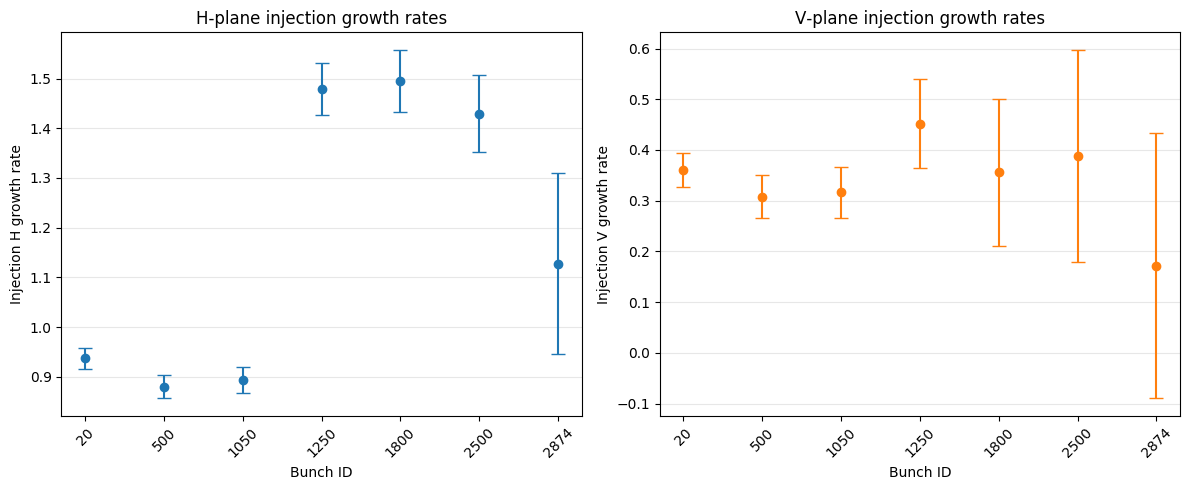

In [14]:
df = pd.DataFrame.from_dict(results, orient="index")
df.index.name = "bunch"
df.sort_index(inplace=True)

# If you want the bunch IDs as an integer column:
df = df.reset_index()

# ───────────────────────────────────────────────────────────────────────────────
# 2) Plotting
# ───────────────────────────────────────────────────────────────────────────────
fig, (axH, axV) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

x = np.arange(len(df))
labels = df["bunch"].astype(str)

# H‑plane
axH.errorbar(x, df["H_slope"], yerr=df["H_stderr"],
             fmt="o", capsize=5, lw=1.5)
axH.set_xticks(x)
axH.set_xticklabels(labels, rotation=45)
axH.set_xlabel("Bunch ID")
axH.set_ylabel("Injection H growth rate")
axH.set_title("H‑plane injection growth rates")
axH.grid(axis="y", alpha=0.3)

# V‑plane
axV.errorbar(x, df["V_slope"], yerr=df["V_stderr"],
             fmt="o", capsize=5, lw=1.5, color="C1")
axV.set_xticks(x)
axV.set_xticklabels(labels, rotation=45)
axV.set_xlabel("Bunch ID")
axV.set_ylabel("Injection V growth rate")
axV.set_title("V‑plane injection growth rates")
axV.grid(axis="y", alpha=0.3)

fig.tight_layout()
plt.show()

# Stable

In [15]:
def load_STABLE(fill: int, pv: str) -> pd.Series:
    """
    Concatenate all STABLE‑mode parquet under
      DATADIR / f"HX:FILLN={fill}" / "HX:BMODE=STABLE"
    for PV `pv`, returning a single tz‑aware Series.
    """
    base = DATADIR / f"HX:FILLN={fill}" / "HX:BMODE=STABLE"
    parts = []
    for pq in base.rglob("*.parquet"):
        try:
            df = pd.read_parquet(pq, columns=[pv])
        except Exception:
            continue
        s = df[pv]
        # make sure the index is UTC‑aware
        s.index = pd.to_datetime(df.index, utc=True, errors="coerce")
        parts.append(s.dropna())
    if not parts:
        raise RuntimeError(f"No STABLE data for {pv}")
    return pd.concat(parts).sort_index()


In [16]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from pathlib import Path
from lmfit import Model
import warnings

# ===============================================================
# Full self‑contained script with both hourly and optics windows
# from start of STABLE period rather than leveling‑on.
# ===============================================================

# -----------------------------
# CONFIG
# -----------------------------
DATADIR   = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363")
fno       = 10739
  # or "B2"

idx_b1    = [20, 500, 750, 1250, 1800, 2250, 2874]
idx_b2    = [20, 500, 1050, 1250, 1800, 2500, 2874]
BUNCH_IDS = idx_b1 if beam.upper()=="B1" else idx_b2

BETA_PV   = "HX:BETASTAR_IP1"
XING_PV   = "LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value"
LEV_PV    = "LHC.LUMISERVER:LumiLevelingIP1:Enable"
THRESH_CA = 120.0

F_SCALE       = 0.1
REL_ERR       = 0.05
ABS_ERR_FLOOR = 0.02
MIN_ERR       = 1e-12
MAKE_HOURLY   = True

# -----------------------------
# HELPERS: timezone, glob, etc.
# -----------------------------
def bsrt_loc_for_beam(beam: str) -> str:
    return "5R4" if beam.upper()=="B1" else "5L4"

def _to_tz(ts, tz):
    return None if ts is None else (ts if ts.tzinfo else ts.tz_localize(tz))

def _parquet_glob(fill_num:int):
    return list((DATADIR/f"HX:FILLN={fill_num}").rglob("*.parquet"))

# -----------------------------
# Robust soft‑L1 line fit
# -----------------------------
_line_model = Model(lambda x,m,b: m*x + b)
def robust_line(x_hours, y):
    yerr = np.maximum(np.maximum(REL_ERR*np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w    = np.minimum(1.0/yerr, 1e4)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        res = _line_model.fit(y, x=x_hours, m=0.0, b=y[0],
                              weights=w, method="least_squares",
                              fit_kws={"loss":"soft_l1","f_scale":F_SCALE})
    return (res.params["m"].value,
            res.params["b"].value,
            res.params["m"].stderr or np.nan,
            res)

# -----------------------------
# Load array PVs (intensity/emittance)
# -----------------------------
def load_bunch_array_for_fill(pv_name, bid_list, fill_num):
    glob = str(DATADIR/f"HX:FILLN={fill_num}" / "**" / "*.parquet")
    raw = (dd.read_parquet(glob, columns=[pv_name],
                           engine="pyarrow",
                           gather_statistics=False)
           .dropna().compute())
    raw.index = pd.to_datetime(raw.index, unit="ns", utc=True)
    raw.sort_index(inplace=True)
    mat = np.stack(raw[pv_name].values)  # nTimes × nBuckets
    return pd.DataFrame(mat[:, bid_list],
                        index=raw.index,
                        columns=[f"B{b}" for b in bid_list])

# -----------------------------
# Load scalar PVs (β*, crossing)
# -----------------------------
def load_scalar_series_for_fill(pv_name, fill_num):
    parts = []
    for pq in _parquet_glob(fill_num):
        try:
            df = pd.read_parquet(pq, columns=[pv_name])
        except KeyError:
            continue
        except:
            continue
        ser = pd.to_numeric(df[pv_name], errors="coerce")
        ser.index = pd.to_datetime(df.index, utc=True, errors="coerce")
        parts.append(ser.dropna())
    if not parts:
        return pd.Series(dtype=float)
    full = pd.concat(parts).sort_index()
    full.name = pv_name
    return full

# -----------------------------
# Compute optics phase markers
# -----------------------------
def phase_markers_from_beta_xing(ser_beta, ser_xing, xing_threshold=THRESH_CA):
    tz = ser_beta.index.tz
    runs = []
    t_prev, v_prev = ser_beta.index[0], ser_beta.iloc[0]
    run_start = t_prev
    for t, v in ser_beta.iloc[1:].items():
        if v != v_prev:
            runs.append((run_start, t_prev))
            run_start, v_prev = t, v
        t_prev = t
    runs.append((run_start, t_prev))
    t_beta_final = max(runs, key=lambda x: x[1] - x[0])[0]

    ca0 = ser_xing.iloc[0]
    idx_leave = np.where(ser_xing.values != ca0)[0]
    t_ca_start = ser_xing.index[idx_leave[0]] if idx_leave.size else ser_xing.index[-1]

    after = ser_xing.index > t_ca_start
    idx_dip = np.where((ser_xing.values <= xing_threshold) & after)[0]
    t_ca_dip = ser_xing.index[idx_dip[0]] if idx_dip.size else ser_xing.index[-1]

    return (_to_tz(t_beta_final, tz),
            _to_tz(t_ca_start, tz),
            _to_tz(t_ca_dip, tz))

# -----------------------------
# Build cumulative windows
# -----------------------------
def build_windows_cumulative(t_on, t_beta, t_ca_start, t_ca_dip, ser_H, ser_V, make_hourly=True):
    tz = ser_H.index.tz
    t_on = _to_tz(t_on, tz)
    data_end = _to_tz(min(ser_H.index.max(), ser_V.index.max()), tz)
    wins = []

    if make_hourly:
        prev = t_on
        hour = 1
        while prev + pd.Timedelta(hours=1) <= data_end:
            nxt = prev + pd.Timedelta(hours=1)
            wins.append((f"{hour}h since stable‑start", None, nxt))
            prev = nxt
            hour += 1

    eps = pd.Timedelta(seconds=1)
    for label, t_end in [("up to β*", t_beta),
                         ("up to CA start", t_ca_start),
                         ("up to CA dip",  t_ca_dip)]:
        if pd.notna(t_end) and (t_end - t_on > eps):
            wins.append((label, None, min(t_end, data_end)))

    # filter out tiny windows
    return [(lab, None, tend) for lab, _, tend in wins if tend - t_on > eps]

# =============================
# Main computation
# =============================
def compute_window_growth_rates_for_bids(fill_num, beam, bids):
    bsrt = bsrt_loc_for_beam(beam)

    # load all arrays
    dfI = load_bunch_array_for_fill(f"LHC.BCTFR.B6R4.{beam}:BUNCH_INTENSITY", bids, fill_num)
    dfH = load_bunch_array_for_fill(f"LHC.BSRT.{bsrt}.{beam}:BUNCH_EMITTANCE_H", bids, fill_num)
    dfV = load_bunch_array_for_fill(f"LHC.BSRT.{bsrt}.{beam}:BUNCH_EMITTANCE_V", bids, fill_num)

    # optics markers
    sb = load_scalar_series_for_fill(BETA_PV, fill_num)
    sx = load_scalar_series_for_fill(XING_PV,  fill_num)
    if sb.empty or sx.empty:
        print("Warning: optics markers missing — only hourly windows will be used.")
        t_beta = t_ca_start = t_ca_dip = pd.NaT
    else:
        t_beta, t_ca_start, t_ca_dip = phase_markers_from_beta_xing(sb, sx, THRESH_CA)

    # ----------------------------------------------------------------
    # START FROM FIRST STABLE SAMPLE, not leveling‑on
    # ----------------------------------------------------------------
    t_on = min(dfH.index.min(), dfV.index.min())
    if t_on.tzinfo is None:
        t_on = t_on.tz_localize("UTC")

    # pick a reference bunch
    ref = next(b for b in bids if not dfH[f"B{b}"].dropna().empty)
    refH, refV = dfH[f"B{ref}"].dropna(), dfV[f"B{ref}"].dropna()

    windows = build_windows_cumulative(t_on, t_beta, t_ca_start, t_ca_dip,
                                       refH, refV, make_hourly=MAKE_HOURLY)

    rows = []
    for label, _, t_end in windows:
        row = {"fill": fill_num, "window": label}
        for b in bids:
            Hs = dfH[f"B{b}"].loc[t_on:t_end].dropna()
            Vs = dfV[f"B{b}"].loc[t_on:t_end].dropna()

            if len(Hs) >= 3:
                xh = (Hs.index - t_on).total_seconds()/3600.0
                sh, _, errH, _ = robust_line(xh.values, Hs.values)
            else:
                sh, errH = np.nan, np.nan

            if len(Vs) >= 3:
                xv = (Vs.index - t_on).total_seconds()/3600.0
                sv, _, errV, _ = robust_line(xv.values, Vs.values)
            else:
                sv, errV = np.nan, np.nan

            row[f"B{b}_H_rate"] = sh
            row[f"B{b}_H_err"]  = errH
            row[f"B{b}_V_rate"] = sv
            row[f"B{b}_V_err"]  = errV

        rows.append(row)

    return pd.DataFrame(rows).set_index(["fill", "window"]).sort_index()

# -----------------------------
# RUN
# -----------------------------
df_window_rates = compute_window_growth_rates_for_bids(fno, beam, BUNCH_IDS)

print("Per-window growth rates (from stable‑start):")
print(df_window_rates)


Per-window growth rates (from stable‑start):
                             B20_H_rate  B20_H_err  B20_V_rate  B20_V_err  \
fill  window                                                                
10739 1h since stable‑start    0.841529   5.382666    0.210005   0.924795   
      2h since stable‑start    0.173247   0.566195    0.083789   0.244467   
      3h since stable‑start    0.125914   0.244523    0.043198   0.109475   
      4h since stable‑start    0.105612   0.122267    0.025460   0.069391   
      5h since stable‑start    0.086163   0.075965    0.031339   0.052231   
      6h since stable‑start    0.057505   0.056988    0.062051   0.042473   
      up to CA dip             0.973576   4.324257    0.218234   0.967739   
      up to CA start           0.973576   4.324257    0.218234   0.967739   
      up to β*                 2.792935   5.996302    0.252919   1.472817   

                             B500_H_rate  B500_H_err  B500_V_rate  B500_V_err  \
fill  window              

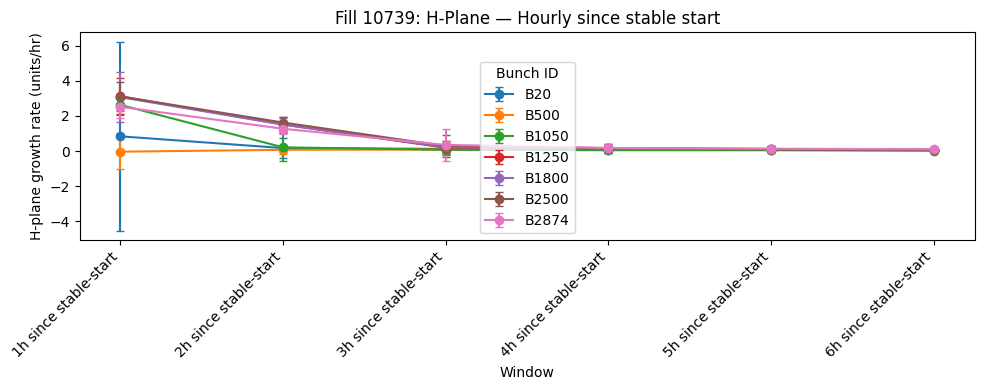

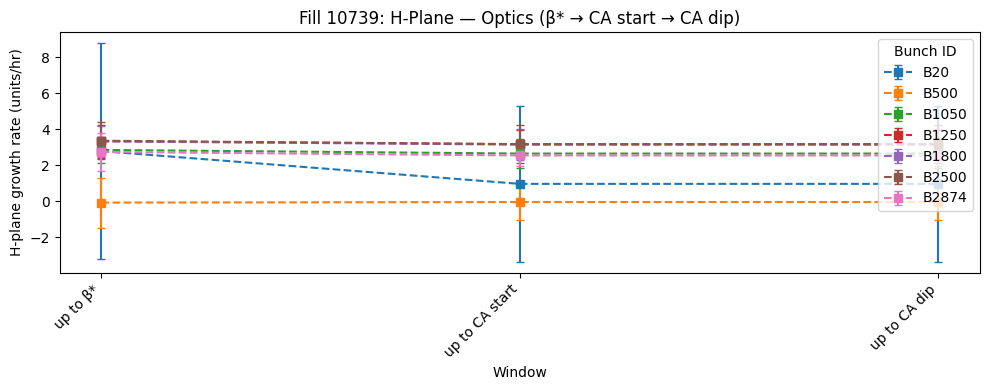

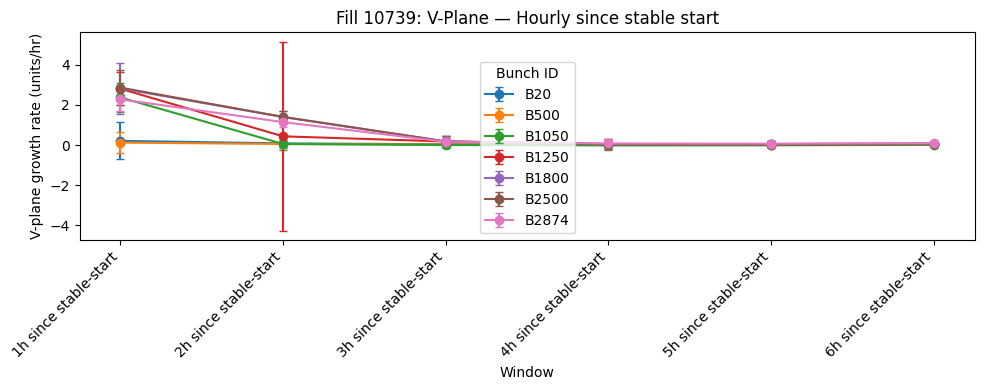

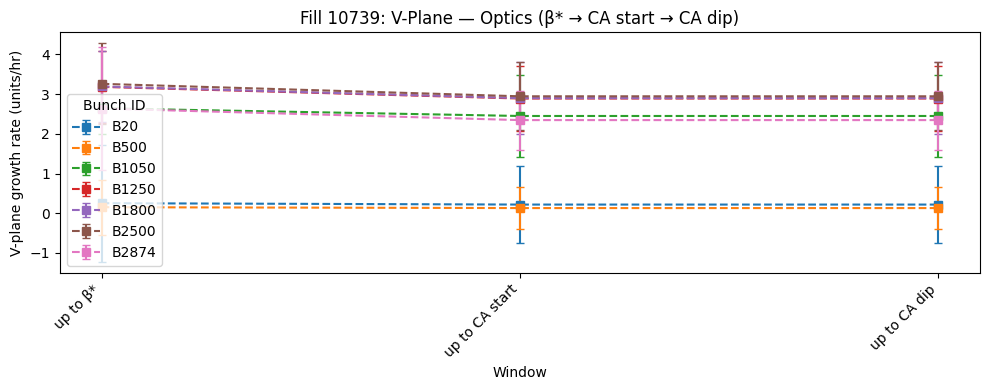

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import re

# 1) Identify all windows in order
all_windows = df_window_rates.index.get_level_values('window').unique().tolist()

# 2) Hourly windows: "1h since lvl-on", "2h …", etc.
hourly_windows = [w for w in all_windows if re.match(r'^\d+h ', w)]

# 3) Optics windows in the exact desired order
optics_desired = ["up to β*", "up to CA start", "up to CA dip"]
# keep only those actually present
optics_windows = [w for w in optics_desired if w in all_windows]

# plotting helper
def plot_plane(plane, windows, title_suffix, marker, linestyle):
    x = np.arange(len(windows))
    plt.figure(figsize=(10,4))
    for bid in BUNCH_IDS:
        rate_col = f"B{bid}_{plane}_rate"
        err_col  = f"B{bid}_{plane}_err"
        # select rows for this fill and these windows
        y    = df_window_rates.loc[(fno, windows), rate_col].values
        yerr = df_window_rates.loc[(fno, windows), err_col].values
        plt.errorbar(x, y, yerr=yerr, fmt=marker+linestyle, capsize=3, label=f"B{bid}")
    plt.xticks(x, windows, rotation=45, ha='right')
    plt.xlabel("Window")
    plt.ylabel(f"{plane}-plane growth rate (units/hr)")
    plt.title(f"Fill {fno}: {plane}-Plane — {title_suffix}")
    plt.legend(title="Bunch ID")
    plt.tight_layout()
    plt.show()

# 4 plots:
# H‑plane, hourly
plot_plane('H', hourly_windows, "Hourly since stable start", marker='o', linestyle='-')

# H‑plane, optics
plot_plane('H', optics_windows, "Optics (β* → CA start → CA dip)", marker='s', linestyle='--')

# V‑plane, hourly
plot_plane('V', hourly_windows, "Hourly since stable start", marker='o', linestyle='-')

# V‑plane, optics
plot_plane('V', optics_windows, "Optics (β* → CA start → CA dip)", marker='s', linestyle='--')


In [18]:
# ===============================================================
# STABLE–period fits  +  windowed growth‑rates   (Fill 10739)
# ===============================================================
import numpy as np
import pandas as pd
import dask.dataframe as dd
from pathlib import Path
from lmfit import Model
import warnings

# ----------------------------- CONFIG -----------------------------
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363")
fno     = 10739
beam    = "B1"                 # <-- set "B2" if needed

idx_b1  = [20, 500, 750, 1250, 1800, 2250, 2874]
idx_b2  = [20, 500, 1050, 1250, 1800, 2500, 2874]
BUNCH_IDS = idx_b1 if beam.upper() == "B1" else idx_b2

# scalar PVs (optics markers)
BETA_PV = "HX:BETASTAR_IP1"
XING_PV = "LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value"
THRESH_CA = 120.0              # crossing‑angle “dip” threshold (µrad)

# robust‑fit hyper‑parameters
F_SCALE       = 0.1
REL_ERR       = 0.05
ABS_ERR_FLOOR = 0.02
MIN_ERR       = 1e-12
MIN_PTS       = 5

# ----------------------------- HELPERS -----------------------------
def bsrt_loc_for_beam(b: str) -> str:
    return "5R4" if b.upper() == "B1" else "5L4"

_line_model = Model(lambda x, m, b: m*x + b)
def robust_line(x_hours, y):
    """
    Soft‑L1 linear fit.  Returns slope, intercept, stderr.
    """
    yerr = np.maximum(np.maximum(REL_ERR*np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w    = np.minimum(1.0 / yerr, 1e4)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        res = _line_model.fit(y, x=x_hours, m=0.0, b=y[0],
                              weights=w, method="least_squares",
                              fit_kws={"loss": "soft_l1", "f_scale": F_SCALE})
    return (res.params["m"].value,
            res.params["b"].value,
            res.params["m"].stderr or np.nan)

def _parquet_glob(fill_num: int):
    return list((DATADIR / f"HX:FILLN={fill_num}").rglob("*.parquet"))

def load_bunch_array_for_fill(pv_name: str, bid_list, fill_num: int) -> pd.DataFrame:
    """
    Read a BSRT (array) PV for the entire fill into a DataFrame
    indexed by UTC nanoseconds, one column per bunch.
    """
    glob = str(DATADIR / f"HX:FILLN={fill_num}" / "**" / "*.parquet")
    raw = (dd.read_parquet(glob, columns=[pv_name],
                           engine="pyarrow",
                           gather_statistics=False)
             .dropna()
             .compute())
    raw.index = pd.to_datetime(raw.index, unit="ns", utc=True)
    raw.sort_index(inplace=True)
    mat = np.stack(raw[pv_name].values)        # nTimes × 3564 (whole ring)
    return pd.DataFrame(mat[:, bid_list],
                        index=raw.index,
                        columns=[f"B{b}" for b in bid_list])

def load_scalar_series_for_fill(pv_name: str, fill_num: int) -> pd.Series:
    """
    Concatenate a scalar PV for the whole fill.
    """
    parts = []
    for pq in _parquet_glob(fill_num):
        try:
            df = pd.read_parquet(pq, columns=[pv_name])
        except (KeyError, Exception):
            continue
        ser = pd.to_numeric(df[pv_name], errors="coerce")
        ser.index = pd.to_datetime(df.index, utc=True, errors="coerce")
        parts.append(ser.dropna())
    if not parts:
        return pd.Series(dtype=float)
    return pd.concat(parts).sort_index()

def phase_markers_from_beta_xing(ser_beta, ser_xing, xing_threshold=THRESH_CA):
    """
    Return three UTC timestamps:
       * t_beta_final – start of final β* plateau
       * t_ca_start   – first time the crossing angle changes
       * t_ca_dip     – first time X‑angle ≤ threshold after change
    """
    tz = ser_beta.index.tz
    # β*  plateau start = start of the longest constant‑β* run
    runs, run_start = [], ser_beta.index[0]
    for t, (prev, now) in zip(ser_beta.index[1:], zip(ser_beta.iloc, ser_beta.iloc[1:])):
        if now != prev:
            runs.append((run_start, t))
            run_start = t
    runs.append((run_start, ser_beta.index[-1]))
    t_beta_final = max(runs, key=lambda r: r[1]-r[0])[0]

    # crossing‑angle markers
    ca0 = ser_xing.iloc[0]
    leave = np.where(ser_xing.values != ca0)[0]
    t_ca_start = ser_xing.index[leave[0]] if leave.size else ser_xing.index[-1]

    after = ser_xing.index > t_ca_start
    idx_dip = np.where((ser_xing.values <= xing_threshold) & after)[0]
    t_ca_dip = ser_xing.index[idx_dip[0]] if idx_dip.size else ser_xing.index[-1]

    return (t_beta_final.tz_convert("UTC"),
            t_ca_start.tz_convert("UTC"),
            t_ca_dip.tz_convert("UTC"))

def build_windows(t_on, t_beta, t_ca_start, t_ca_dip,
                  last_time, make_hourly=True):
    """
    Produce a list of (label, t_end) windows starting at t_on.
    """
    wins = []
    if make_hourly:
        nxt = t_on + pd.Timedelta(hours=1)
        hr  = 1
        while nxt <= last_time:
            wins.append((f"{hr}h since stable‑start", nxt))
            hr  += 1
            nxt += pd.Timedelta(hours=1)

    for lab, t_end in [("up to β*", t_beta),
                       ("up to CA start", t_ca_start),
                       ("up to CA dip",  t_ca_dip)]:
        if pd.notna(t_end) and t_end > t_on and t_end <= last_time:
            wins.append((lab, t_end))

    # keep chronological order and drop duplicates
    seen, ordered = set(), []
    for lab, t in wins:
        if lab not in seen:
            ordered.append((lab, t))
            seen.add(lab)
    return ordered

# ===============================================================
# MAIN
# ===============================================================
def compute_stable_fits_and_windows(fill_num, beam, bids,
                                    make_hourly=True, return_stab_df=True):

    bsrt_loc = bsrt_loc_for_beam(beam)

    # 1) load BSRT arrays
    dfH = load_bunch_array_for_fill(f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H",
                                    bids, fill_num)
    dfV = load_bunch_array_for_fill(f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V",
                                    bids, fill_num)

    # 2) t_on = earliest STABLE sample
    t_on = min(dfH.index.min(), dfV.index.min()).tz_convert("UTC")

    # 3) per‑bunch STABLE fits  -> stab_df
    stab_rows = {}
    for b in bids:
        col = f"B{b}"
        Hser, Vser = dfH[col].dropna(), dfV[col].dropna()
        if len(Hser) < MIN_PTS or len(Vser) < MIN_PTS:
            continue
        t0 = min(Hser.index[0], Vser.index[0])

        xh = (Hser.index - t0).total_seconds()/3600.0
        mH, bH, eH = robust_line(xh, Hser.values)

        xv = (Vser.index - t0).total_seconds()/3600.0
        mV, bV, eV = robust_line(xv, Vser.values)

        stab_rows[b] = {"t0_st": t0, "H_slope": mH, "H_intercept": bH,
                        "H_stderr": eH, "V_slope": mV, "V_intercept": bV,
                        "V_stderr": eV, "npts_H": len(Hser), "npts_V": len(Vser)}

    stab_df = pd.DataFrame.from_dict(stab_rows, orient="index")
    stab_df.index.name = "bunch"

    # 4) optics markers  (only needed for window labels)
    sb = load_scalar_series_for_fill(BETA_PV, fill_num)
    sx = load_scalar_series_for_fill(XING_PV,  fill_num)
    if sb.empty or sx.empty:
        t_beta = t_ca_start = t_ca_dip = pd.NaT
        print("⚠️  Optics markers missing – optics windows disabled.")
    else:
        t_beta, t_ca_start, t_ca_dip = phase_markers_from_beta_xing(sb, sx)

    # last common time‑stamp across both planes
    t_last = min(dfH.index.max(), dfV.index.max())

    windows = build_windows(t_on, t_beta, t_ca_start, t_ca_dip,
                            t_last, make_hourly)

    # 5) growth‑rate fits inside each window
    win_rows = []
    for lab, t_end in windows:
        row = {"fill": fill_num, "window": lab}
        for b in bids:
            col = f"B{b}"
            Hs = dfH[col].loc[t_on:t_end].dropna()
            Vs = dfV[col].loc[t_on:t_end].dropna()

            if len(Hs) >= 3:
                xh = (Hs.index - t_on).total_seconds()/3600.0
                sh, _, eH = robust_line(xh, Hs.values)
            else:
                sh = eH = np.nan

            if len(Vs) >= 3:
                xv = (Vs.index - t_on).total_seconds()/3600.0
                sv, _, eV = robust_line(xv, Vs.values)
            else:
                sv = eV = np.nan

            row[f"B{b}_H_rate"] = sh
            row[f"B{b}_H_err"]  = eH
            row[f"B{b}_V_rate"] = sv
            row[f"B{b}_V_err"]  = eV
        win_rows.append(row)

    df_window_rates = (pd.DataFrame(win_rows)
                         .set_index(["fill", "window"])
                         .sort_index())

    return (df_window_rates, stab_df) if return_stab_df else df_window_rates

# ----------------------------- RUN -----------------------------
df_window_rates, stab_df = compute_stable_fits_and_windows(
                               fno, beam, BUNCH_IDS,
                               make_hourly=True, return_stab_df=True)

print("\n=== STABLE‑period per‑bunch fits (stab_df) ===")
print(stab_df.head())

print("\n=== Growth‑rate fits by window (df_window_rates) ===")
print(df_window_rates.head(10))



=== STABLE‑period per‑bunch fits (stab_df) ===
                                    t0_st   H_slope  H_intercept  H_stderr  \
bunch                                                                        
20    2025-06-20 00:38:29.033138575+00:00  0.076476     2.486755  0.068338   
500   2025-06-20 00:38:29.033138575+00:00  0.080069     2.377724  0.039116   
750   2025-06-20 00:38:29.033138575+00:00  0.324333     1.927606  0.237476   
1250  2025-06-20 00:38:29.033138575+00:00  0.119862     2.366158  0.111203   
1800  2025-06-20 00:38:29.033138575+00:00  0.123107     2.337146  0.131213   

        V_slope  V_intercept  V_stderr  npts_H  npts_V  
bunch                                                   
20     0.185946     1.900394  0.059258    2202    2202  
500    0.170180     1.884382  0.034264    2202    2202  
750    0.151145     1.727420  0.104407    2202    2202  
1250   0.208530     1.913465  0.118624    2202    2202  
1800   0.212716     1.877889  0.124044    2202    2202  

=== G

Loading BSRT STABLE parquet …
First STABLE timestamp = 2025-06-20 00:38:29.033138575+00:00


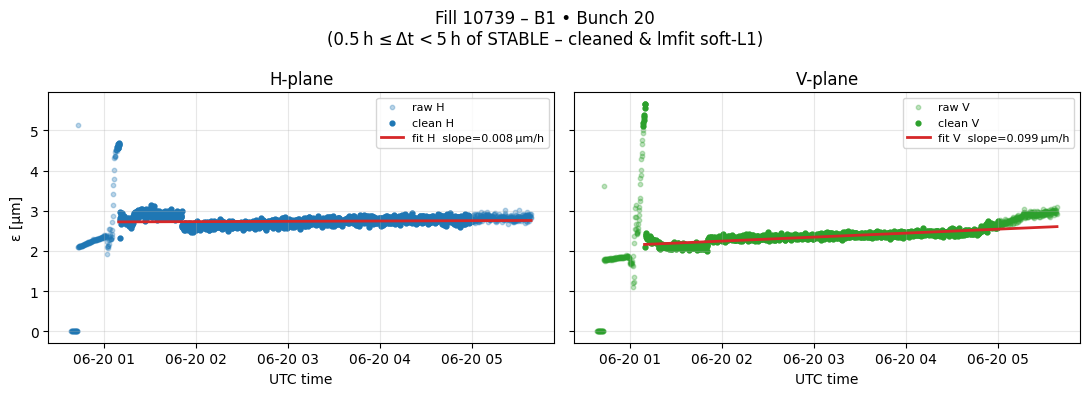

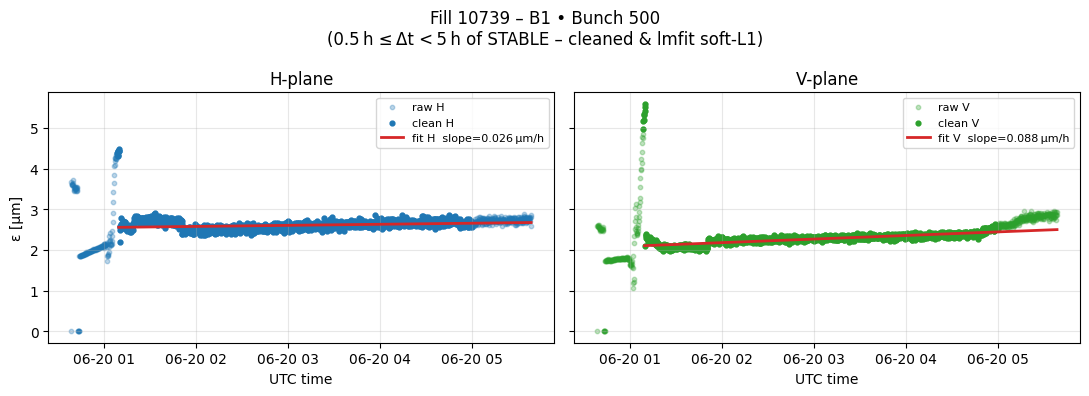

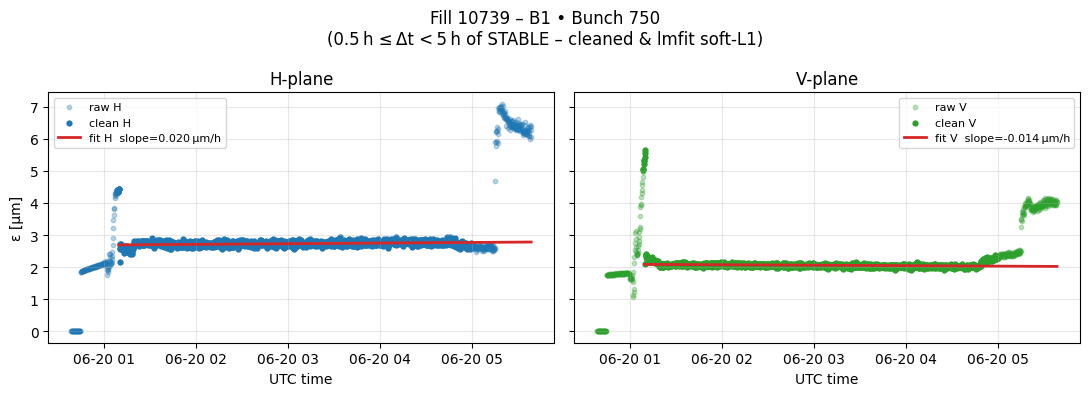

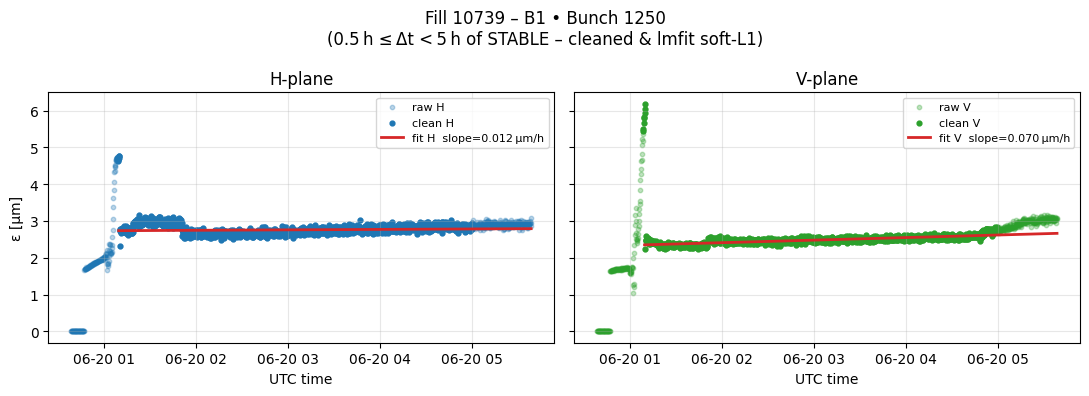

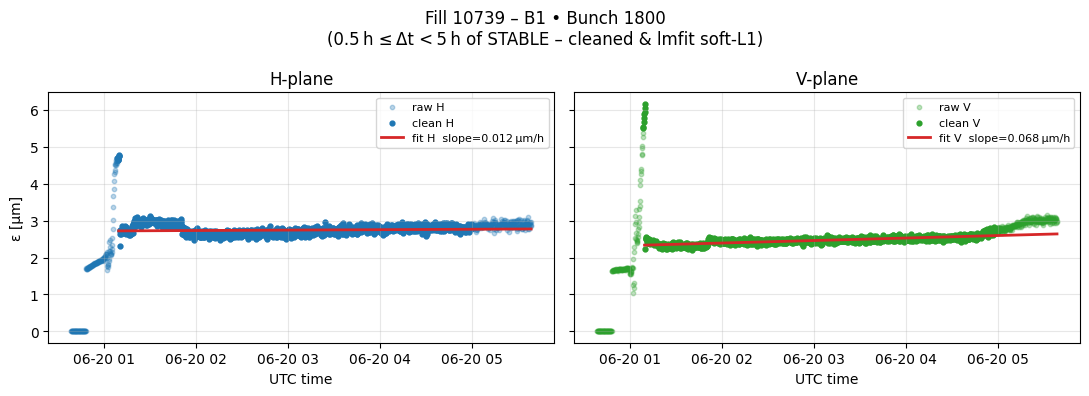

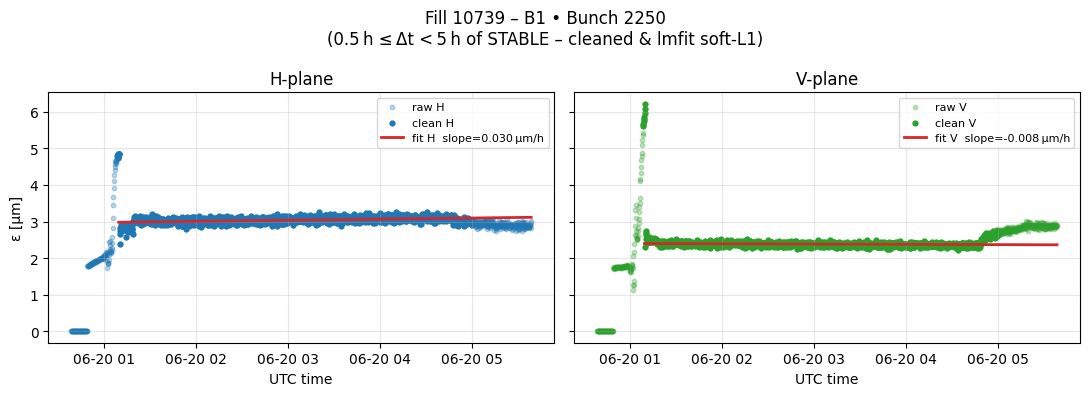

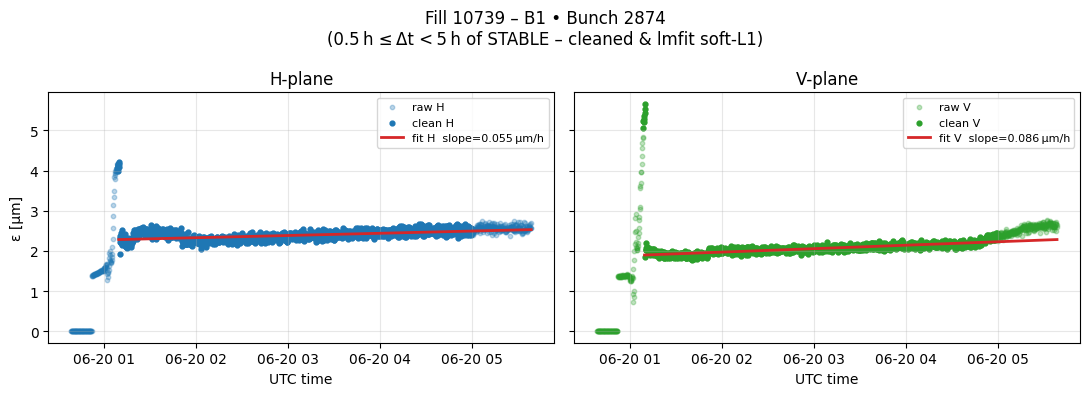


Fit results (0.5 h ≤ Δt < 5 h, µm & µm/h):
      H_slope  H_intercept   H_err  V_slope  V_intercept   V_err   n_H   n_V
20     0.0078       2.7217  0.0039   0.0988       2.1599  0.0034  1324  1324
500    0.0262       2.5568  0.0035   0.0881       2.1049  0.0033  1324  1324
750    0.0200       2.6929  0.0029  -0.0141       2.0865  0.0031  1324  1324
1250   0.0121       2.7359  0.0042   0.0697       2.3498  0.0034  1324  1324
1800   0.0115       2.7227  0.0042   0.0678       2.3353  0.0034  1324  1324
2250   0.0300       2.9807  0.0032  -0.0078       2.3993  0.0034  1324  1324
2874   0.0553       2.2834  0.0035   0.0859       1.8988  0.0032  1324  1324


In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
STABLE‑period emittance growth  • Fill 10739  • Beam B1
fit interval = 0.5 h ≤ Δt < 5 h after first STABLE sample
"""

# -------------- imports & config --------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import dask.dataframe as dd, warnings
from pathlib import Path
from lmfit  import Model

DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363")
FILL    = 10739
BEAM    = "B1"

SLOTS_B1 = [20, 500, 750, 1250, 1800, 2250, 2874]
SLOTS_B2 = [20, 500, 1050, 1250, 1800, 2500, 2874]
BUNCH_IDS = SLOTS_B1 if BEAM.upper()=="B1" else SLOTS_B2

bsrt_loc = "5R4" if BEAM.upper()=="B1" else "5L4"
PV_H = f"LHC.BSRT.{bsrt_loc}.{BEAM}:BUNCH_EMITTANCE_H"
PV_V = f"LHC.BSRT.{bsrt_loc}.{BEAM}:BUNCH_EMITTANCE_V"

#F_SCALE       = 0.1
#REL_ERR       = 0.05
#ABS_ERR_FLOOR = 0.02
#MIN_ERR       = 1e-12
#MAX_WEIGHT    = 1e3
F_SCALE       = 1.0      #   ↑ from 0.10 → 1.0  (flatter soft‑L1 curve)
REL_ERR       = 0.10     #   ↑ 10 % relative error floor
ABS_ERR_FLOOR = 0.05     #   ↑ 0.05 µm absolute floor
MIN_ERR       = 1e-10    #   ↑ numeric lower bound two decades larger
MAX_WEIGHT    = 1e2 

# -------------- helpers --------------
def _glob_parquets(fill):
    return list((DATADIR / f"HX:FILLN={fill}").rglob("*.parquet"))

def load_bunch_array(pv, bids, fill):
    glob = str(DATADIR/f"HX:FILLN={fill}" / "**" / "*.parquet")
    raw  = (dd.read_parquet(glob, columns=[pv],
                            gather_statistics=False, engine="pyarrow")
             .dropna().compute())
    raw.index = pd.to_datetime(raw.index, unit="ns", utc=True)
    raw.sort_index(inplace=True)
    mat = np.stack(raw[pv].values)
    return pd.DataFrame(mat[:, bids],
                        index   = raw.index,
                        columns = [f"B{b}" for b in bids])

_line_model = Model(lambda x, m, b: m*x + b)
def robust_line(xh, y):
    yerr = np.maximum(np.maximum(REL_ERR*np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w    = np.minimum(1.0/yerr, MAX_WEIGHT)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        res = _line_model.fit(y, x=xh, m=0.0, b=y[0],
                              weights=w, method="least_squares",
                              fit_kws={"loss":"soft_l1", "f_scale":F_SCALE})
    return res.params["m"].value, res.params["b"].value, res.params["m"].stderr or np.nan

def clean_series(ser, t_on):
    """keep 0.5 h ≤ Δt  AND  timestamp < 05:00 UTC ; drop zeros & >2×median outliers"""
    dt   = ser.index - t_on
    t_cut= t_on.normalize() + pd.Timedelta(hours=5)      # 05:00 UTC on that day
    mask = (dt >= pd.Timedelta(minutes=30)) & (ser.index < t_cut)   # ← UPDATED
    ser  = ser[mask].copy()
    if ser.empty:
        return ser
    ser[ser == 0] = np.nan
    med = ser.rolling(61, center=True, min_periods=1).median()
    ser[(ser - med).abs() > 2 * med] = np.nan
    return ser.dropna()

# -------------- load BSRT STABLE --------------
print("Loading BSRT STABLE parquet …")
dfH = load_bunch_array(PV_H, BUNCH_IDS, FILL)
dfV = load_bunch_array(PV_V, BUNCH_IDS, FILL)

t_on = min(dfH.index.min(), dfV.index.min())
if t_on.tzinfo is None:
    t_on = t_on.tz_localize("UTC")
print("First STABLE timestamp =", t_on)

# -------------- per‑bunch fit & plot --------------
results = {}
for bid in BUNCH_IDS:
    col = f"B{bid}"
    Hraw = dfH[col].loc[t_on:t_on+pd.Timedelta(hours=5)]
    Vraw = dfV[col].loc[t_on:t_on+pd.Timedelta(hours=5)]

    Hcln = clean_series(Hraw, t_on)
    Vcln = clean_series(Vraw, t_on)

    if len(Hcln) < 3 and len(Vcln) < 3:
        print(f"B{bid}: not enough clean points → skipped")
        continue

    # lmfit
    if len(Hcln) >= 3:
        xh = (Hcln.index - Hcln.index[0]).total_seconds()/3600.0
        mH, bH, eH = robust_line(xh, Hcln.values)
    else:
        mH = bH = eH = np.nan

    if len(Vcln) >= 3:
        xv = (Vcln.index - Vcln.index[0]).total_seconds()/3600.0
        mV, bV, eV = robust_line(xv, Vcln.values)
    else:
        mV = bV = eV = np.nan

    results[bid] = dict(H_slope=mH, H_intercept=bH, H_err=eH,
                        V_slope=mV, V_intercept=bV, V_err=eV,
                        n_H=len(Hcln), n_V=len(Vcln))

    # ----------- plot ----------
    t_grid = pd.date_range(t_on+pd.Timedelta(minutes=31),
                           t_on+pd.Timedelta(hours=5)-pd.Timedelta(seconds=1),
                           periods=150)

    H_fit = bH + mH * (t_grid - (Hcln.index[0] if len(Hcln) else t_grid[0])
                       ).total_seconds()/3600.0
    V_fit = bV + mV * (t_grid - (Vcln.index[0] if len(Vcln) else t_grid[0])
                       ).total_seconds()/3600.0

    fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharey=True)
    fig.suptitle(f"Fill {FILL} – {BEAM} • Bunch {bid}\n"
                 "(0.5 h ≤ Δt < 5 h of STABLE – cleaned & lmfit soft‑L1)")

    # H
    ax[0].scatter(Hraw.index, Hraw, s=10, c="tab:blue", alpha=0.3, label="raw H")
    ax[0].scatter(Hcln.index, Hcln, s=12, c="tab:blue", label="clean H")
    if np.isfinite(mH):
        ax[0].plot(t_grid, H_fit, c="tab:red", lw=2,
                   label=f"fit H  slope={mH:.3f} µm/h")
    ax[0].set_xlabel("UTC time"); ax[0].set_ylabel("ε [µm]")
    ax[0].set_title("H‑plane"); ax[0].grid(alpha=.3); ax[0].legend(fontsize=8)

    # V
    ax[1].scatter(Vraw.index, Vraw, s=10, c="tab:green", alpha=0.3, label="raw V")
    ax[1].scatter(Vcln.index, Vcln, s=12, c="tab:green", label="clean V")
    if np.isfinite(mV):
        ax[1].plot(t_grid, V_fit, c="tab:red", lw=2,
                   label=f"fit V  slope={mV:.3f} µm/h")
    ax[1].set_xlabel("UTC time"); ax[1].set_title("V‑plane")
    ax[1].grid(alpha=.3); ax[1].legend(fontsize=8)

    plt.tight_layout(); plt.show()

# -------------- summary table --------------
res_df = pd.DataFrame.from_dict(results, orient="index").sort_index()
pd.set_option("display.precision", 4)
print("\nFit results (0.5 h ≤ Δt < 5 h, µm & µm/h):")
print(res_df)


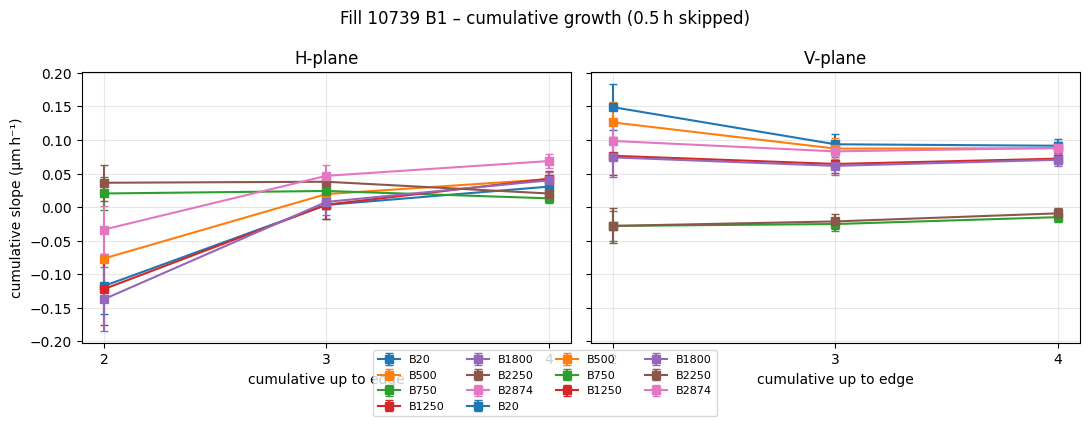

In [20]:
# ======================================================================
# Windowed growth‑rate analysis (cleaned BSRT data, lmfit soft‑L1)
# ======================================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
from pathlib import Path
from lmfit import Model
import dask.dataframe as dd

# 0) CONFIG ----------------------------------------------------------------
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363")
fno, beam = 10739, "B1"                       # adjust if needed
idx_b1  = [20, 500, 750, 1250, 1800, 2250, 2874]
idx_b2  = [20, 500, 1050, 1250, 1800, 2500, 2874]
BUNCH_IDS = idx_b1 if beam.upper()=="B1" else idx_b2
bsrt_loc = "5R4" if beam.upper()=="B1" else "5L4"
H_PV     = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_H"
V_PV     = f"LHC.BSRT.{bsrt_loc}.{beam}:BUNCH_EMITTANCE_V"
F_SCALE, REL_ERR, ABS_ERR_FLOOR, MIN_ERR = 0.1, 0.05, 0.02, 1e-12

# 1) HELPERS --------------------------------------------------------------
def load_bunch_array_for_fill(pv_name, bid_list, fill_num):
    glob = str(DATADIR/f"HX:FILLN={fill_num}" / "**" / "*.parquet")
    raw  = (dd.read_parquet(glob, columns=[pv_name], engine="pyarrow",
                            gather_statistics=False).dropna().compute())
    raw.index = pd.to_datetime(raw.index, unit="ns", utc=True)
    raw.sort_index(inplace=True)
    mat = np.stack(raw[pv_name].values)
    return pd.DataFrame(mat[:, bid_list],
                        index=raw.index,
                        columns=[f"B{b}" for b in bid_list])

_line_model = Model(lambda x,m,b: m*x + b)
def robust_line(x_hours, y):
    yerr = np.maximum(np.maximum(REL_ERR*np.abs(y), ABS_ERR_FLOOR), MIN_ERR)
    w    = np.minimum(1.0/yerr, 1e4)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        res=_line_model.fit(y, x=x_hours, m=0.0, b=y[0],
                            weights=w, method="least_squares",
                            fit_kws={"loss":"soft_l1","f_scale":F_SCALE})
    return res.params["m"].value, res.params["b"].value, res.params["m"].stderr

# 2) LOAD STABLE‑DATA -----------------------------------------------------
dfH = load_bunch_array_for_fill(H_PV, BUNCH_IDS, fno)
dfV = load_bunch_array_for_fill(V_PV, BUNCH_IDS, fno)

# 3) WINDOW EDGES ---------------------------------------------------------
t_on = min(dfH.index.min(), dfV.index.min())
if t_on.tzinfo is None: t_on = t_on.tz_localize("UTC")
edges = [t_on + pd.Timedelta(minutes=30) + i*pd.Timedelta(hours=1)
         for i in range(5)]                     # 0.5 → 4.5 h
win_labels = ["1", "2", "3", "4"]

def clean_series(ser):
    dt   = ser.index - t_on
    mask = (dt >= pd.Timedelta(minutes=30)) & (dt < pd.Timedelta(hours=5))
    ser  = ser[mask]; ser = ser[ser != 0]
    if ser.empty: return ser
    med = ser.median()
    return ser[(ser - med).abs() < 2*med]

def fit_or_nan(ser, t0):
    if len(ser) < 3: return np.nan, np.nan
    xh = (ser.index - t0).total_seconds()/3600.0
    m, _, err = robust_line(xh, ser.values)
    return m, err

# 4) PER‑BUNCH / PER‑WINDOW FITS ------------------------------------------
rows=[]
for bid in BUNCH_IDS:
    Hc = clean_series(dfH[f"B{bid}"].dropna())
    Vc = clean_series(dfV[f"B{bid}"].dropna())
    if Hc.empty and Vc.empty: continue
    for i in range(4):
        w0, w1 = edges[i], edges[i+1]
        lbl = f"{win_labels[i]} h window"
        mH,eH = fit_or_nan(Hc.loc[w0:w1], w0); mV,eV = fit_or_nan(Vc.loc[w0:w1], w0)
        mHc,eHc = fit_or_nan(Hc.loc[edges[0]:w1], edges[0])
        mVc,eVc = fit_or_nan(Vc.loc[edges[0]:w1], edges[0])
        rows.append(dict(window=lbl,bunch=bid,
                         H_rate=mH,H_err=eH,V_rate=mV,V_err=eV,
                         H_cum=mHc,H_cerr=eHc,V_cum=mVc,V_cerr=eVc))

win_df = (pd.DataFrame(rows)
            .set_index(["window","bunch"])
            .sort_index())

# 5) PLOTS  ––– **skip first window**  ------------------------------------
plt.style.use("default"); keep = [1,2,3]        # windows “2”, “3”, “4”


# cumulative
fig,axs = plt.subplots(1,2, figsize=(11,4), sharey=True)
for p,plane in enumerate(["H","V"]):
    for bid in BUNCH_IDS:
        try: sub = win_df.xs(bid, level="bunch")
        except KeyError: continue
        y = sub[f"{plane}_cum" ].iloc[keep]; e = sub[f"{plane}_cerr"].iloc[keep]
        axs[p].errorbar(np.arange(len(keep)), y, yerr=e,
                        marker="s", ls="-", capsize=3, label=f"B{bid}")
    axs[p].set_xticks(np.arange(len(keep))); axs[p].set_xticklabels(win_labels[1:])
    axs[p].set_xlabel("cumulative up to edge"); axs[p].set_title(f"{plane}‑plane")
    axs[p].grid(alpha=.3)
axs[0].set_ylabel("cumulative slope (µm h⁻¹)")
fig.suptitle(f"Fill {fno} {beam} – cumulative growth (0.5 h skipped)")
fig.legend(ncol=4, fontsize=8, loc="lower center", bbox_to_anchor=(0.5,-0.05))
plt.tight_layout(); plt.show()
